In [371]:
import numpy as np
import sklearn as sk
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils.random import sample_without_replacement
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.tree import export_graphviz
from subprocess import call
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from IPython.display import Image
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

In [372]:
data = datasets.load_iris()
iris = pd.DataFrame(np.column_stack((data.data, data.target)), columns = data.feature_names + ["target"])
iris["target"] = iris["target"].astype(int)
iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [373]:
desc = iris.describe()
desc

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


From the matrix we can see the basic statistical propertey of each column.

In [374]:
def data_cleansing(data, fill = None):
    # handle with empty value
    print("Check If the column contain Nan value")
    print(data.isna().any())
    if not fill is None:
        print("Replace all empty values with {}".format(fill))
        data.fillna()
    else:
        print("Drop all rows that contains empty values")
        data.dropna()
        
    # handle with outliers 
    # detect outliers in each column and remove them 
    print("Detecting Outliers")
    indexs = []
    for col in data.columns[:-1]:
        IR = desc[col]["75%"] - desc[col]["25%"]
        ifOutlier = lambda x: x < desc[col]["25%"] - 1.5 * IR or x > desc[col]["75%"] + 1.5 * IR
        index = data[col][data[col].apply(ifOutlier)].index
        indexs.extend(index)
    
    # now index is the list the rows that contain outlier. Remove them
    
    print("Rows with outlier: ", indexs)
    data.drop(indexs)
    data.reset_index(drop = True)

data = data_cleansing(iris)


Check If the column contain Nan value
sepal length (cm)    False
sepal width (cm)     False
petal length (cm)    False
petal width (cm)     False
target               False
dtype: bool
Drop all rows that contains empty values
Detecting Outliers
Rows with outlier:  [15, 32, 33, 60]


This function will remove the columns with empty value, or fill empty with value provided.
For iris data set, there is no missing value.


This function will detect outliers in each column using quantile method, and remove the rows with outlier

In [375]:
def statistical_relationship(data):
    
    # Correlation
    corr = data.corr()
    corr.to_csv("correlation.csv")
    
    # LR
    lr = LogisticRegression()
    rfe = RFE(lr, 1)
    fit = rfe.fit(data[data.columns[:-1]], iris["target"])
    print(fit.ranking_)
    
    return sns.heatmap(corr)

The funcion finds the relationship between features by finding the correlation matrix, output as csv, and visualize the result using heat map

The function use logistic regression to check the significance order of features.

[4 2 3 1]


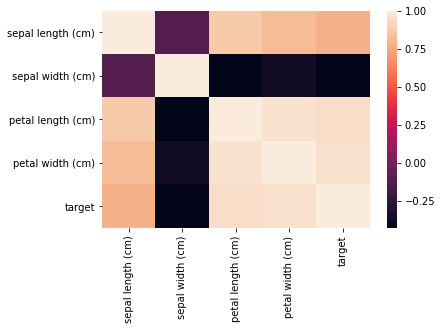

In [376]:
statistical_relationship(iris)

We can see that sepal length is not correlated with other features and targets. However, the rest three features have strong corelation between each other.

From the rank list of four features, we can see that petal width (cm) is the most significant to target, followed by sepal width, petal length, sepal length. 

In [377]:
random.seed(123)

irisc = deepcopy(iris)

index = sample_without_replacement(irisc.shape[0], 50)
irisc.loc[:,irisc.columns[:-1]] = normalize(irisc[irisc.columns[:-1]])
test = irisc.iloc[index]
test.reset_index(drop = True,inplace = True)
train = irisc[~irisc.index.isin(index)]
train.reset_index(drop = True,inplace = True)


result_test = iris.iloc[index]
result_train = iris.iloc[~iris.index.isin(index)]


## Random Forest

rdf = RandomForestClassifier()
rdf.fit(train[train.columns[:-1]],train["target"])
print(rdf.score(test[test.columns[:-1]],test["target"]))
result_test["Random Forest"] = rdf.predict(test[test.columns[:-1]])
result_train["Random Forest"] = rdf.predict(train[train.columns[:-1]])

export_graphviz(rdf.estimators_[9], out_file = 'tree.dot')
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

## Nueral Network

nn = MLPClassifier(activation = "relu", 
                   solver = "adam",
                  learning_rate_init = 0.01)
nn.fit(train[train.columns[:-1]],train["target"])
print(nn.score(test[test.columns[:-1]],test["target"]))

result_test["Neural Network"] = nn.predict(test[test.columns[:-1]])
result_train["Neural Network"] = nn.predict(train[train.columns[:-1]])
results = pd.concat([result_train, result_test])
results.to_csv("results.csv")
#normalize(iris[])

0.96
0.96


We use Random Forest and Neural Network to classify the iris data. we can see the accuracy is above 95% for both classifier.

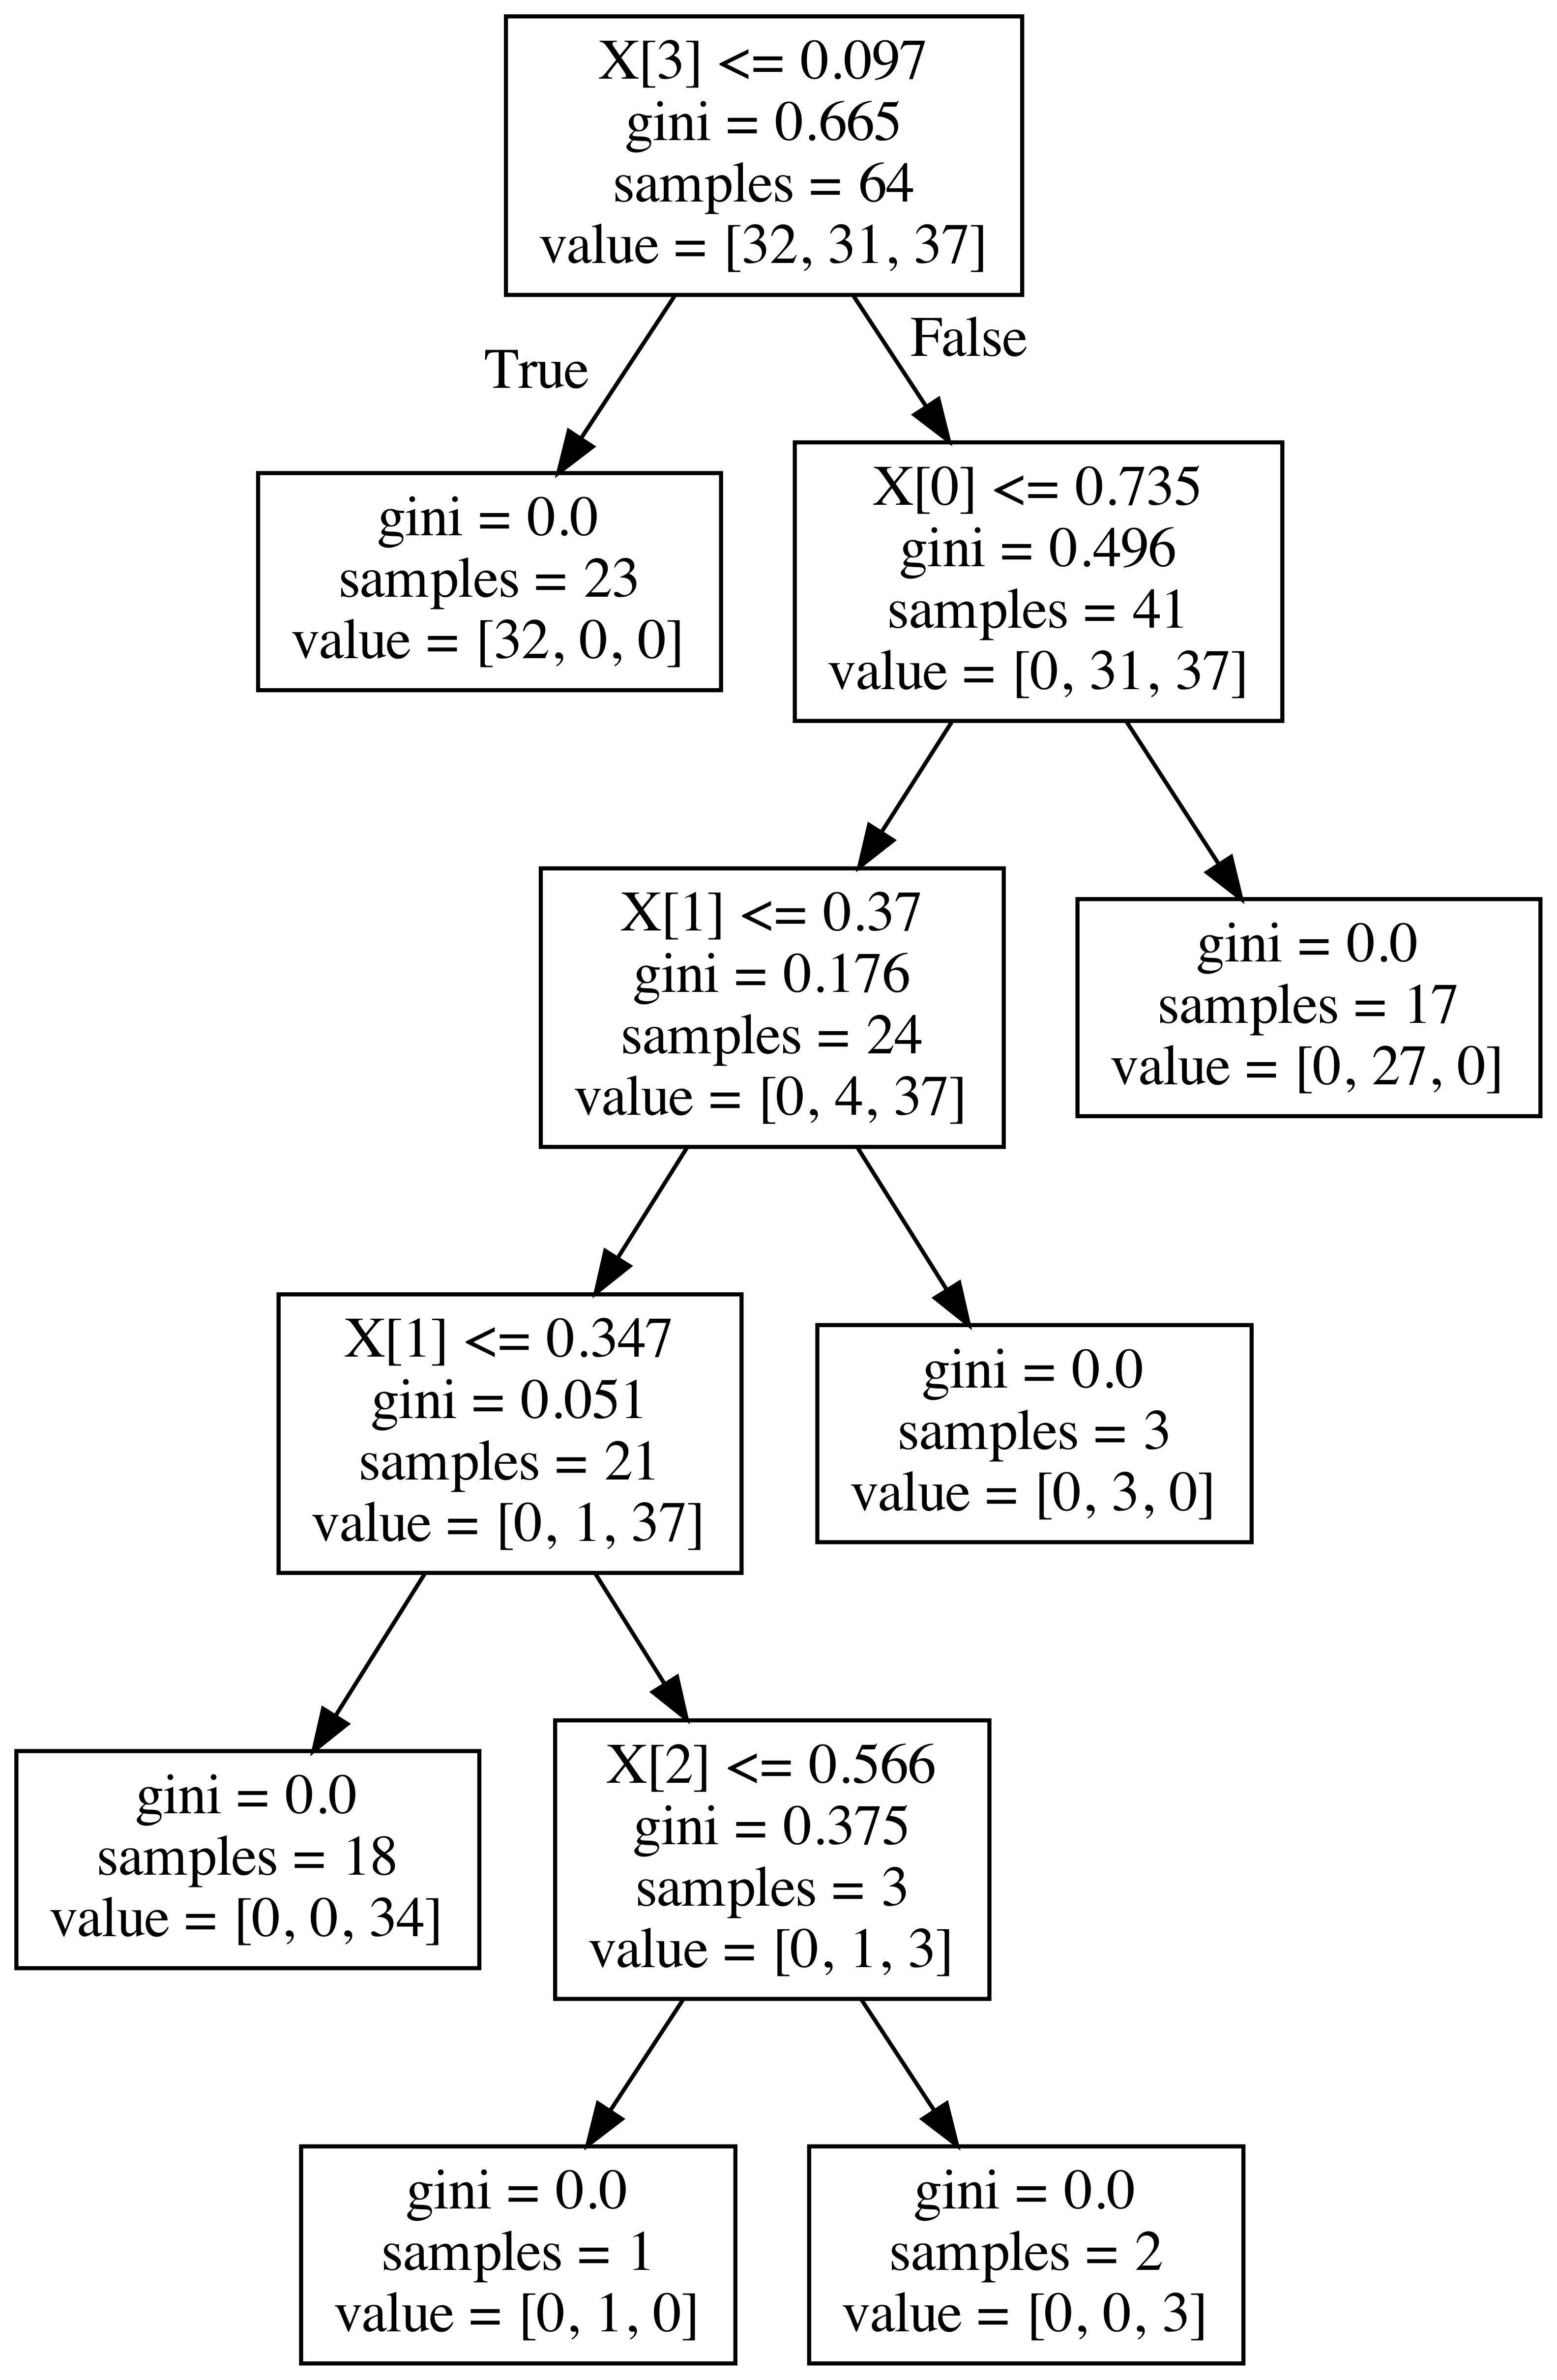

In [378]:
# visualize the 10th tree of the random forest

Image(filename = 'tree.png')

The 10th tree of the random forest is visualized here.